# **Prédiction des prix des voitures :**

Une entreprise aimerait s'implémenter sur un nouveau marché et donc estimer au mieux le prix des voitures déjà présentes.

Le but de ce notebook est de réaliser une application pour determiner le prix d'une voiture en fonction de ses caractéristiques en se basant sur du machine learning.

## *Analyse exploratoire des données :*

*Import librairies :*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

*Import jeu de données :*

In [2]:
df = pd.read_csv('CarPrice_Assignment.xls')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


*Analyse du jeu de données :*

Drop `car_ID` et `CarName`

In [3]:
df.drop(['car_ID'], axis=1, inplace=True)
df.drop(['CarName'], axis=1, inplace=True)

In [4]:
df.shape

(205, 24)

205 lignes, 24 colonnes 

In [6]:
df.isnull().sum()

symboling           0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [7]:
df.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


*Encodage :*

In [8]:
le = LabelEncoder()
df['fueltype'] = le.fit_transform(df.fueltype)
class_fueltype = le.classes_
df['aspiration'] = le.fit_transform(df.aspiration)
class_aspiration = le.classes_
df['carbody'] = le.fit_transform(df.carbody)
class_carbody = le.classes_
df['drivewheel'] = le.fit_transform(df.drivewheel)
class_drivewheel = le.classes_
df['enginelocation'] = le.fit_transform(df.enginelocation)
class_enginelocation = le.classes_
df['enginetype'] = le.fit_transform(df.enginetype)
class_enginetype = le.classes_
df['fuelsystem'] = le.fit_transform(df.fuelsystem)
class_fuelsystem = le.classes_

In [9]:
to_replace = {
    "two" : 2,
    "three" : 3,
    "four" : 4,
    "five" : 5,
    "six" : 6,
    "eight" : 8,
    "twelve" : 12
}
df.replace(to_replace=to_replace, inplace=True)

*Correlation :*

In [10]:
df_corr = df.corr()['price'][:-1] # -1 car la dernière colonne est price
golden_features_list = df_corr[abs(df_corr) > 0.6].sort_values(ascending=False)
print("Il y a {} valeurs fortement corrélées avec le prix:\n{}".format(len(golden_features_list), golden_features_list))

Il y a 8 valeurs fortement corrélées avec le prix:
enginesize        0.874145
curbweight        0.835305
horsepower        0.808139
carwidth          0.759325
cylindernumber    0.718305
carlength         0.682920
citympg          -0.685751
highwaympg       -0.697599
Name: price, dtype: float64


*Select K_Best :*

In [11]:
y = df['price']
X_raw = df.drop('price', axis=1)

selector = SelectKBest(f_regression, k=8)
X = selector.fit_transform(X_raw, y)

In [12]:
best_features = selector.get_feature_names_out()
best_features

array(['carlength', 'carwidth', 'curbweight', 'cylindernumber',
       'enginesize', 'horsepower', 'citympg', 'highwaympg'], dtype=object)

## *Machine Learning :*

*Split du dataset :*

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Mise à l'échelle :*

In [14]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

## *Regression Linéaire :*

In [15]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_scale, y_train)

LinearRegression()

*Score du modèle :*

In [16]:
lin_reg_y_pred = lin_reg_model.predict(X_test_scale)
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_y_pred))
lin_reg_r2 = r2_score(y_test,lin_reg_y_pred)
print("RMSE sur jeu de test",lin_reg_rmse)
print("R² sur jeu de test",lin_reg_r2)

RMSE sur jeu de test 3827.6073177298476
R² sur jeu de test 0.8144181457254067


## *KNN Regressor :*
*Choix du meilleur hyper-paramètre:*

In [17]:
param_grid = {'n_neighbors' : np.arange(1,50), 'metric' : ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=4)
grid.fit(X_train_scale, y_train)
KNN_regressor = grid.best_estimator_
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

*Score du modèle :*

In [18]:
KNN_y_pred = KNN_regressor.predict(X_test_scale)
KNN_rmse = np.sqrt(mean_squared_error(y_test, KNN_y_pred))
KNN_r2 = r2_score(y_test,KNN_y_pred)
print("RMSE sur jeu de test",KNN_rmse)
print("R² sur jeu de test",KNN_r2)

RMSE sur jeu de test 3496.412222633747
R² sur jeu de test 0.8451447203428072


## *Regression Polynomiale :*
*Création des features polynomiales :*

In [19]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

*Split et mise à l'échelle du nouveau jeu de données :*

In [20]:
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)
scaler_poly = StandardScaler()
poly_X_train_scale = scaler_poly.fit_transform(poly_X_train)
poly_X_test_scale = scaler_poly.transform(poly_X_test)

*Création du modèle polynomial :*

In [21]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_X_train_scale, poly_y_train)

LinearRegression()

*Score du modèle :*

In [22]:
poly_reg_y_pred = poly_reg_model.predict(poly_X_test_scale)
poly_reg_rmse = np.sqrt(mean_squared_error(poly_y_test, poly_reg_y_pred))
poly_reg_r2 = r2_score(poly_y_test,poly_reg_y_pred)
print("RMSE sur jeu de test",poly_reg_rmse)
print("R² sur jeu de test",poly_reg_r2)

RMSE sur jeu de test 3126.5128581394215
R² sur jeu de test 0.876177036041624


## *DecisionTreeRegressor :*

*GridSearchCV :*

In [23]:
tree_para = {
    'max_depth' : np.arange(1,10),
    'min_samples_leaf' : np.arange(1,20)
}
grid = GridSearchCV(DecisionTreeRegressor(random_state=42), tree_para, cv=5)
grid.fit(X_train_scale, y_train)
grid.best_estimator_

DecisionTreeRegressor(max_depth=6, min_samples_leaf=3, random_state=42)

*Score :*

In [24]:
tree_regressor = grid.best_estimator_

tree_reg_y_pred = tree_regressor.predict(X_test_scale)
tree_reg_rmse = np.sqrt(mean_squared_error(y_test, tree_reg_y_pred))
tree_reg_r2 = tree_regressor.score(X_test_scale, y_test)
print('rmse :', tree_reg_rmse)
print('r² score :',tree_reg_r2)

rmse : 2807.354771815022
r² score : 0.9001667165288332


*Affichage de l'arbre :*

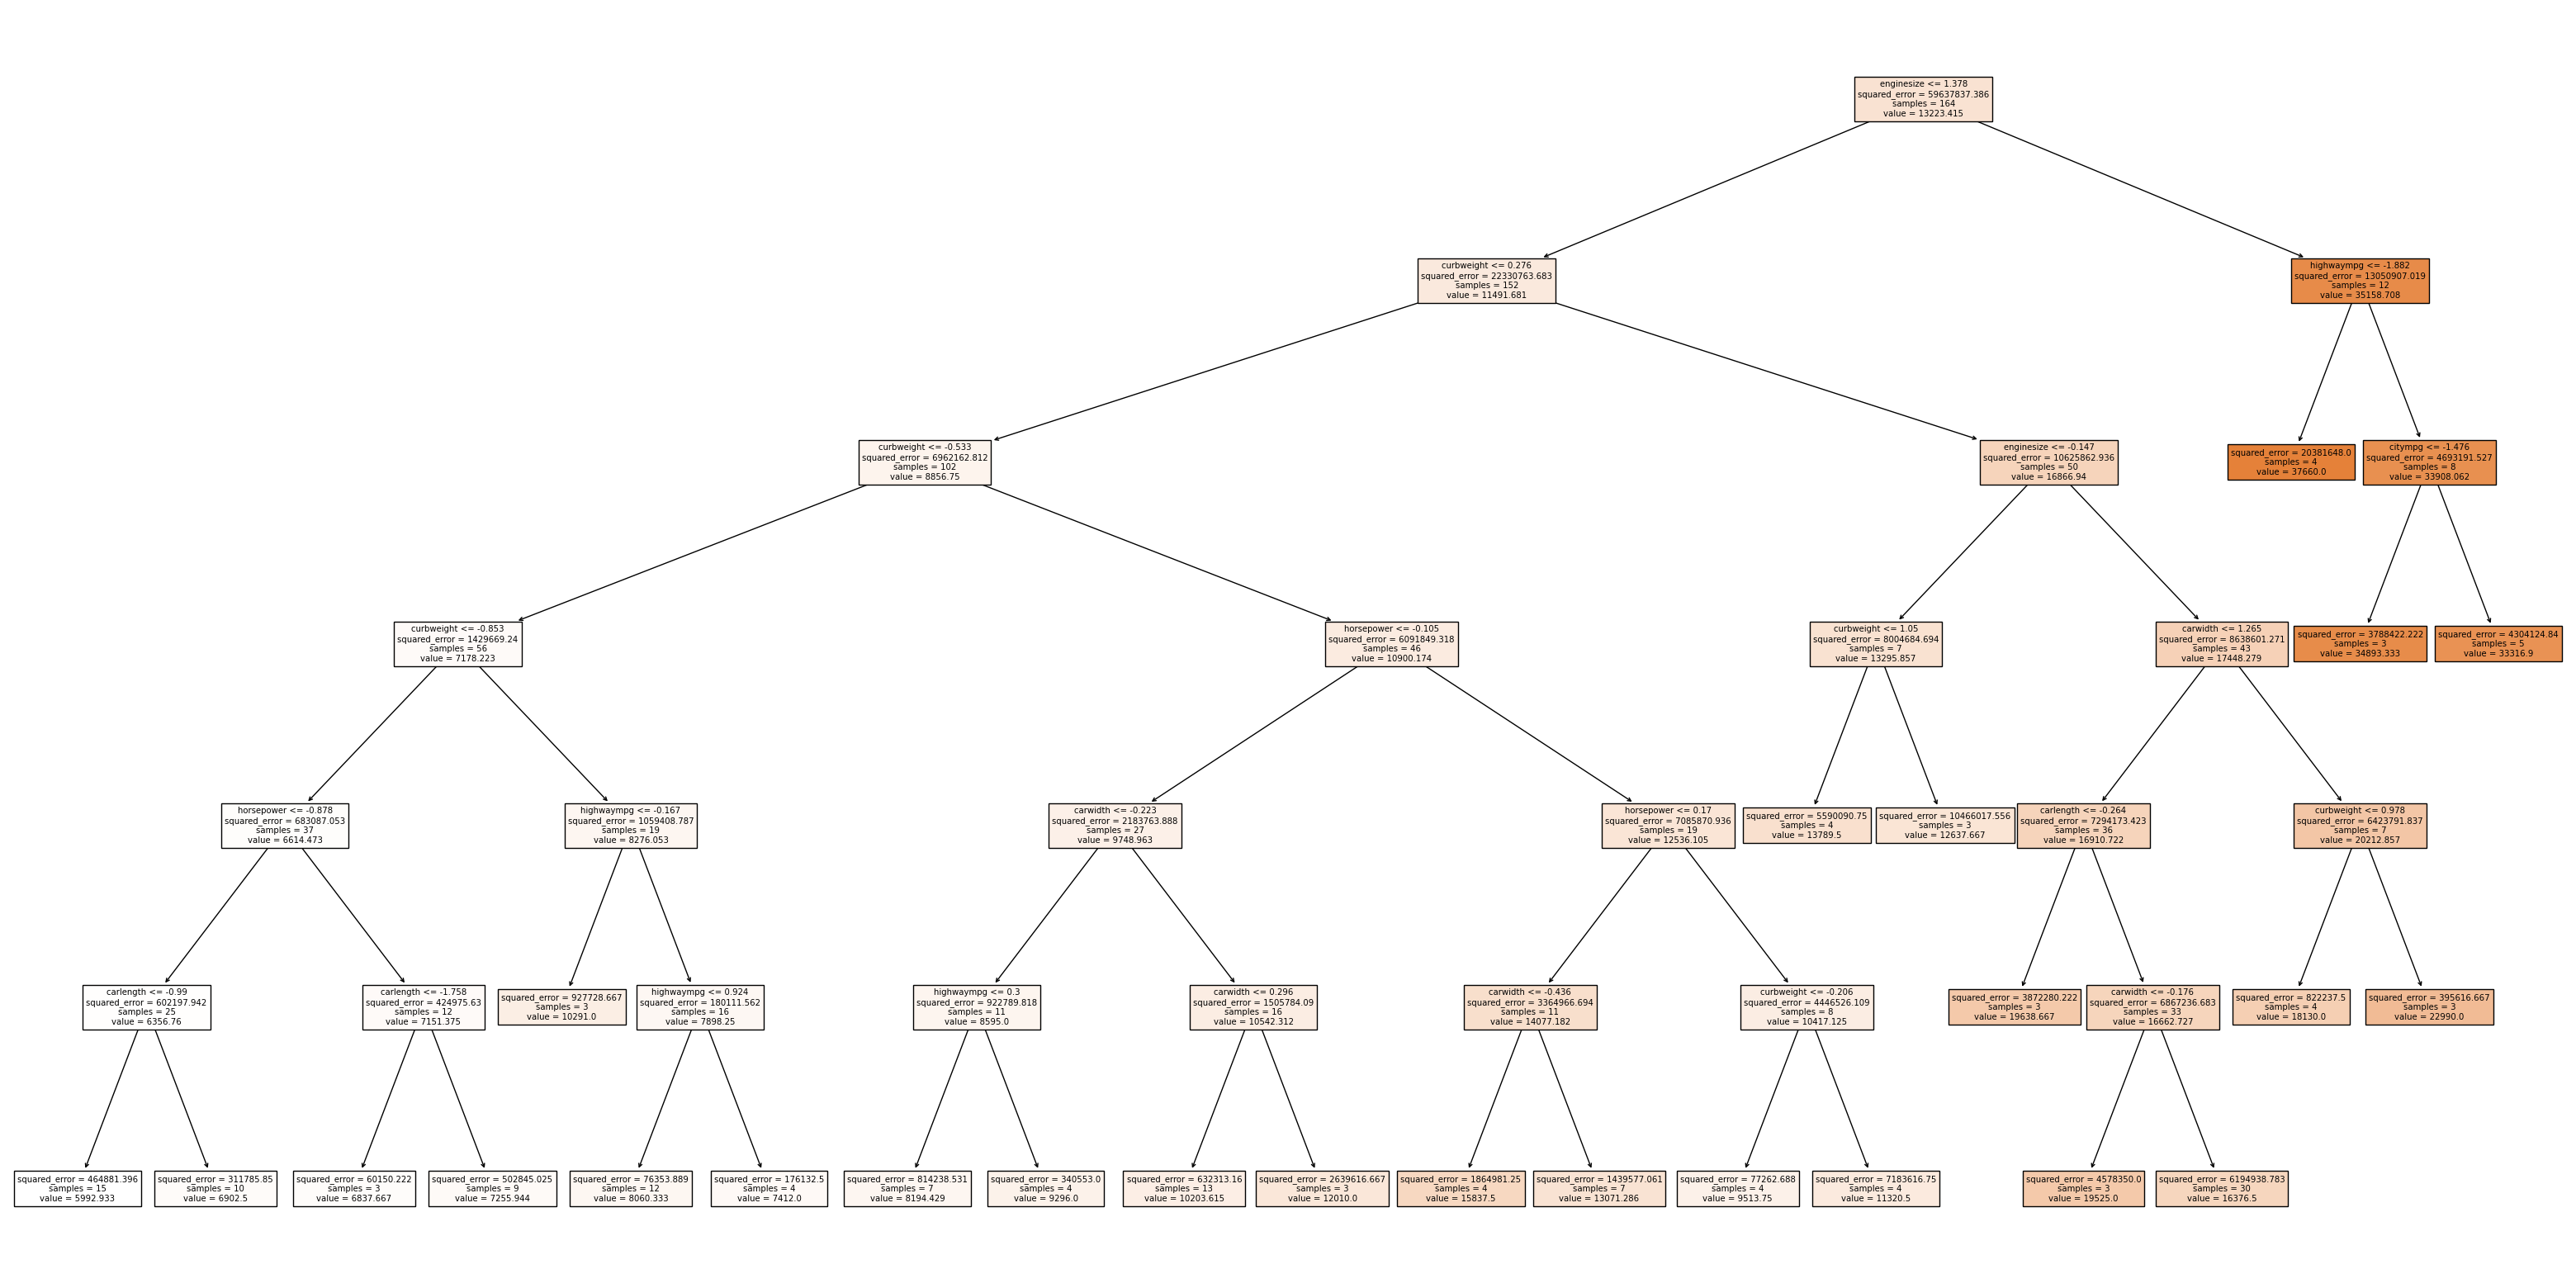

In [25]:
plt.figure(figsize=(40,20))
tree.plot_tree(tree_regressor, feature_names=best_features, filled=True)
plt.show()

# ENSEMBLE LEARNING

## *Bagging :*
*RandomForestRegressor :*

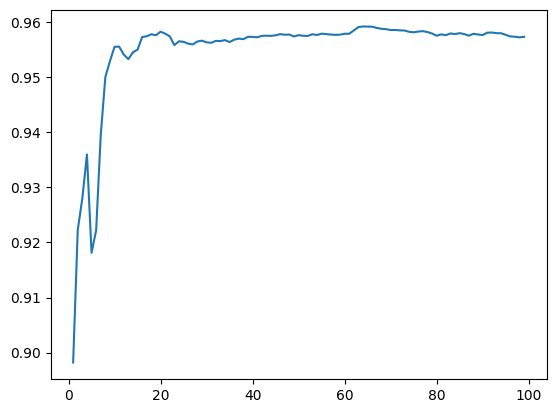

In [26]:
scores = []
for i in np.arange(1,100):
    model = RandomForestRegressor(n_estimators=i, random_state = 42)
    model.fit(X_train_scale, y_train)
    scores.append(model.score(X_test_scale, y_test))

plt.plot(np.arange(1,100), scores)

In [27]:
forest_score_max = max(scores)
index = scores.index(forest_score_max)

print("Meilleur score : n_estimators", index+1, "score", forest_score_max)

Meilleur score : n_estimators 64 score 0.959210773919299


In [28]:
forest = RandomForestRegressor(n_estimators=64, random_state=42)
forest.fit(X_train_scale, y_train)

forest_y_pred = forest.predict(X_test_scale)
forest_rmse = np.sqrt(mean_squared_error(y_test, forest_y_pred))
print('rmse :', forest_rmse)
print('r² score :',forest.score(X_test_scale, y_test))

rmse : 1794.4540995466953
r² score : 0.959210773919299


*BaggingRegressor :*

In [29]:
bagging_reg = BaggingRegressor(random_state=42)
bagging_reg.fit(X_train_scale, y_train)

bagging_y_pred = bagging_reg.predict(X_test_scale)
bagging_reg_rmse = np.sqrt(mean_squared_error(y_test, bagging_y_pred))
bagging_reg_r2 = bagging_reg.score(X_test_scale, y_test)
print('rmse :', bagging_reg_rmse)
print('r² score :', bagging_reg_r2)

rmse : 1864.600656213927
r² score : 0.9559594815615822


## *Boosting :*

*Adaboost :*

In [30]:
adaboost = AdaBoostRegressor(n_estimators=100, random_state=42)
adaboost.fit(X_train_scale, y_train)

adaboost_y_pred = adaboost.predict(X_test_scale)
adaboost_rmse = np.sqrt(mean_squared_error(y_test, adaboost_y_pred))
adaboost_r2 = adaboost.score(X_test_scale, y_test)
print('rmse :', adaboost_rmse)
print('r² score :',adaboost_r2)

rmse : 2720.17847247545
r² score : 0.9062706606571449


*Gardientboosting :*

In [31]:
gboost = GradientBoostingRegressor(n_estimators=100, random_state=42)
gboost.fit(X_train_scale, y_train)

gboost_y_pred = gboost.predict(X_test_scale)
gboost_rmse = np.sqrt(mean_squared_error(y_test, gboost_y_pred))
gboost_r2 = gboost.score(X_test_scale,y_test)
print('rmse :', gboost_rmse)
print('r² score :', gboost_r2)

rmse : 2471.607258384337
r² score : 0.9226180479328452


*XGBoost :*

In [32]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train_scale, y_train)

xg_reg_y_pred = xg_reg.predict(X_test_scale)
xg_reg_rmse = np.sqrt(mean_squared_error(y_test, xg_reg_y_pred))
xg_reg_r2 = xg_reg.score(X_test_scale, y_test)
print('rmse :', xg_reg_rmse)
print('r² score:', xg_reg_r2)

rmse : 2579.123684483145
r² score: 0.9157392934165078


### *Stacking :*

In [33]:
stacking_reg = StackingRegressor([('Linear', lin_reg_model),
                                ('KNN', KNN_regressor),
                                ('Polynomial', poly_reg_model),
                               ('DecisionTree', forest)],
                               final_estimator=LinearRegression())
stacking_reg.fit(X_train_scale, y_train)

stacking_reg_y_pred = stacking_reg.predict(X_test_scale)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_reg_y_pred))
stacking_r2 = stacking_reg.score(X_test_scale, y_test)
print('rmse :', stacking_rmse)
print('r² score :', stacking_r2)

rmse : 1859.8931911941586
r² score : 0.956181574689189


# SCORES :

In [53]:
final_scores = {
    'Regression linéaire' : lin_reg_r2,
    'KNN Regressor' : KNN_r2,
    'Regression Polynomiale' : poly_reg_r2,
    'DecisionTreeRegressor' : tree_reg_r2,
    'RandomForestRegressor' : forest_score_max,
    'BaggingRegressor' : bagging_reg_r2,
    'AdaBoostRegressor' : adaboost_r2,
    'GradientBoostingRegressor' : gboost_r2,
    'XGBoostRegressor' : xg_reg_r2,
    'StackingRegressor' : stacking_r2
}

models = pd.DataFrame({
    'Model' : final_scores.keys(),
    'r2_score' : final_scores.values()
})

In [56]:
px.bar(data_frame = models.sort_values(by='r2_score', ascending=True), x = 'r2_score', y = 'Model', color = 'r2_score', template = 'ggplot2', title = 'Models Comparison')

In [36]:
final_rmse = {
    'Regression linéaire' : lin_reg_rmse,
    'KNN Regressor' : KNN_rmse,
    'Regression Polynomiale' : poly_reg_rmse,
    'DecisionTreeRegressor' : tree_reg_rmse,
    'RandomForestRegressor' : forest_rmse,
    'BaggingRegressor' : bagging_reg_rmse,
    'AdaBoostRegressor' : adaboost_rmse,
    'GradientBoostingRegressor' : gboost_rmse,
    'XGBoostRegressor' : xg_reg_rmse,
    'StackingRegressor' : stacking_rmse
}

## *Meilleur modèle :*

In [37]:
best_score = max(final_scores.values())
best_model = max(final_scores, key=final_scores.get)

print("Le meilleur modèle est", best_model, "avec un r2_score de", round(best_score, 2), "et un RMSE de", round(forest_rmse))

Le meilleur modèle est RandomForestRegressor avec un r2_score de 0.96 et un RMSE de 1794


## *Sauvegarde modele + scaler :*

In [38]:
joblib.dump(forest, 'final_model')
joblib.dump(scaler, 'scaler')

['scaler']